## Project: Computer simulation of a roadblock model of translational control
## Author: Gabin ROUSSEAU

### Build a first TASEP-emulating function that uses the exclusion principle described in:
#### Function arguments:

**t = time (number of iterations)**

**a = first site loading probability**

**b = final site unloading probability**

**p = site transition probability**

**L = length of the lattice**

**l = length of a particle passed in the lattice**

**State of an individual site** of index i = **Si** (i=1, ..., L)
With S = {1 if occupied, 0 if empty}

_**Note:** The state of occupation refers to a particle's tracked site exclusively, and the exclusion principle will take that into account to allow passage from one site to another. If all sites blocked by a particle were considered "occupied", it would cause problems when counting the particles on the lattice, especially if the model will end up having to qualify particle types._

**pi = probability of hopping from site i to site i+1** (for i=1,...,L-1) = assumed to be constant here. Should be equal to 1 for phase diagram testing!


Site states will be grouped in the **configuration array C = [S1,..., SL]**

Hopping probabilities will be grouped in the **progression arrary P = [p1,...,pL-1]**


---
_roadblock_ini - v0.2_

In [1]:
###############################################################################
#
#       roadblock_ini (rini) v0.2
#                               January 2024
#
#       Author: Gabin Rousseau
#
###############################################################################

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import random

import seaborn as sns
sns.set(style="darkgrid")

import pandas as pd
import csv

In [31]:
def rini(t=100, L=30, l=1, a=0.75, b=0.75, p=1):
    '''
    
    roadblock_ini v0.2 
    (rini for short)
    
    DESCRIPTION:
    This is the second version of Gabin ROUSSEAU's model for the roadblock effect of mRNA-binding Ssd1 on translation initiation in S. cerevisiae.
    The function will check at each iteration which sites are occupied by a tracked particle unit and randomly assign the order in which each particle's fate is decided, along with loading or unloading opportunities.
    This version of the model aims to fit the inhomogeneous TASEP formulaism proposed by MacDonald, Gibbs and Pipkin in 1968 (https://doi.org/10.1002/bip.1968.360060102).
    
    -->Runs an inhomogeneous TASEP model of user-defined parameters that allows for a set particle of variable length, to which the exclusion process self-adapts.
    Returns a dataset containing for each time point:
    1 - The total number of particles that initiated up to that time point "passed_total". (i.e., passed through the lattice. Not to be confused with loading, where a particle enters the lattice. Named so because we model after the ribosome PIC.)
    2 - The state of each lattice site Si (0 or 1). i = 1 ,..., L
    3 - The lattice-wide density d = number of particles / L. Measured at the end of an iteration.
    
    ARGUMENTS: t, L, l, a, b, p
    t: number of iterations to run the TASEP model; DEFAULT: t=100
    L: lattice length;                              DEFAULT: L=30
    l: particle length;                             DEFAULT: l=1
    a: probability of loading;                      DEFAULT: a=0.75
    b: probability of unloading;                    DEFAULT: b=0.75
    p: probability of scanning (i.e., site hopping);DEFAULT: p=1
    
    LIMITATIONS:
    Rates/probabilities are capped at 1.
    Only one type of particle (length l) is taken into account.
    Backstepping is not allowed (as opposed to PASEP).
    
    CHANGELOG:
       
    Added probabilities as arguments rather than embedded constants and added default values for all arguments.
    Added local density measurements that can be added to the output. Start by checking lattice-wide, values for l=1 could be used to check the phase diagram.
    
    
    

    '''
    
    #set initial variables
    S_start=0
    C=[]
    P=[]
    for i in range(L):
        C.append(S_start)
        if i < L-1:
            P.append(p) 
            
    passed_total=0 #counter for particles that terminated scanning
    
    #prepare returned dataset
    rini_data={'time':[0], 'passed_total':[0], 'density':[0]}
    loc1=0
    for S in C:
        loc1+=1
        rini_data.update({f'S{loc1}':[0]})
    
    #exclusion rule variables
    acondition=C[0:l]
    
    
    #launch model
    for iteration in range(t):
        #for this iteration, make a randomly ordered list of site indicies to check: S1 for loading, sites occupied by a tracked particle unit for scanning, SL for unloading
        iterparticle=['load']
        loc2=-1
        for S in C[0:L]:
            loc2+=1
            if S==1:
                iterparticle.append(loc2)       
        random.shuffle(iterparticle)
        
        #go through each step of the iteration in the random order
        
        for step in iterparticle:
            if step == 'load':
                #LOADING
                acontext=C[0:l]
                if acontext==acondition:
                    a_roll=random.uniform(0,1)
                    if a_roll<=a:    
                        C[0]+=1
                    
            elif step == L-1:
                #UNLOADING
                if C[L-1]==1:
                    b_roll=random.uniform(0,1)
                    if b_roll<=b:
                        C[L-1]-=1
                        passed_total+=1
                                          
            else:
                #SCANNING
                if step <= L-l-1:
                    if C[step+l]==0:
                        p_roll=random.uniform(0,1)
                        if p_roll<= P[step]:
                            C[step]-=1
                            C[step+1]+=1
                                   
                else: #should only affect particles that can't be blocked by another of the same type downstream
                    p_roll=random.uniform(0,1)
                    if p_roll<= P[step]:
                        C[step]-=1
                        C[step+1]+=1
        
     
        #update dataset
        rini_data.setdefault('time', []).append(iteration+1)
        
        rini_data.setdefault('passed_total', []).append(passed_total)
        
        particle_count=0
        
        loc3=0
        for S in C:
            loc3+=1
            rini_data.setdefault(f'S{loc3}', []).append(S)
            if S==1:
                particle_count+=1
        
        d=round(particle_count/L,2) #lattice density rounded to 2 decimals
        rini_data.setdefault('density', []).append(d)
        
    return pd.DataFrame(data=rini_data)

In [32]:
model_test=rini()
#model_test.to_csv(path_or_buf='/home/gabin_r/Documents/ROADBLOCK_ub/rini_v0-1_output/table.csv')

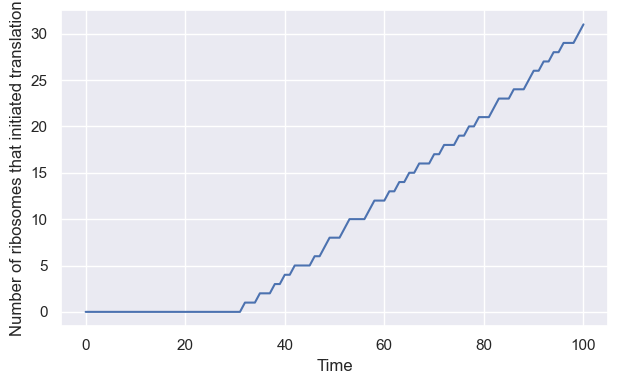

In [33]:
#INITIATED VS. TIME model_test
plt.figure(figsize = (12, 4))
plt.subplot(121)
sns.lineplot(x='time', y='passed_total', data=model_test)

plt.xlabel('Time')
plt.ylabel('Number of ribosomes that initiated translation')

plt.tight_layout()
plt.show();

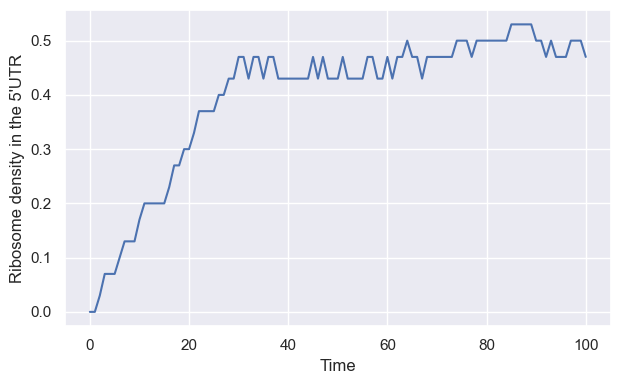

In [34]:
#DENSITY VS. TIME Max current (a and b >1/2)
#EXPECTED: d=1/2
plt.figure(figsize = (12, 4))
plt.subplot(121)
sns.lineplot(x='time', y='density', data=model_test)

plt.xlabel('Time')
plt.ylabel("Ribosome density in the 5'UTR")

plt.tight_layout()
plt.show();

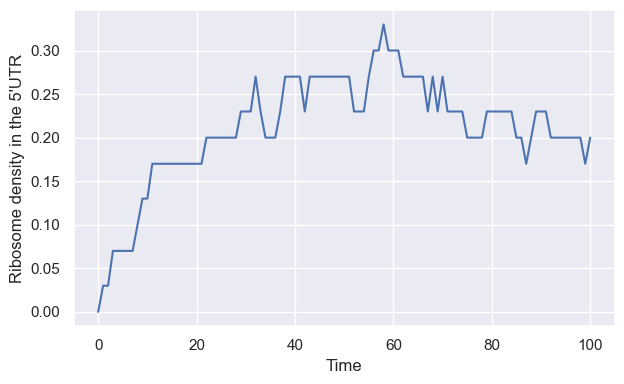

In [35]:
#DENSITY VS. TIME Low density (a < 1/2 and a < b)
#EXPECTED: d=a
plt.figure(figsize = (12, 4))
plt.subplot(121)
sns.lineplot(x='time', y='density', data=rini(a=0.25))

plt.xlabel('Time')
plt.ylabel("Ribosome density in the 5'UTR")

plt.tight_layout()
plt.show();

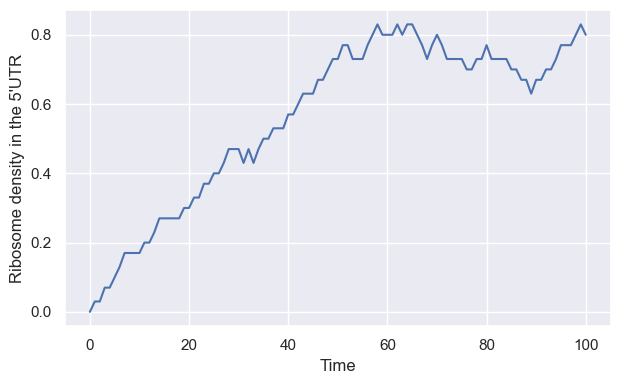

In [52]:
#DENSITY VS. TIME High density (b < 1/2 and a > b)
#EXPECTED: d=a
plt.figure(figsize = (12, 4))
plt.subplot(121)
sns.lineplot(x='time', y='density', data=rini(b=0.3))

plt.xlabel('Time')
plt.ylabel("Ribosome density in the 5'UTR")

plt.tight_layout()
plt.show();